In [1]:
import numpy as np
from gurobipy import *
from scipy.stats import beta
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import time


In [2]:
M = 2
#supply

N = 8
#demand

T = 4
#period

num_i = M
num_j = N
num_t = T

bar_I = np.array([1 for i in range(num_i)])
# I_binary,initial solution for benders

Z = np.array([(250*num_j)/num_i for i in range(num_i)])
# Z'i_capacity

#demand = 200+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_t*num_j, 0.01), 2, 4)
#zeta=demand.reshape(num_t,num_j)
#for t in range(num_t):
#    for j in range(num_j):
#        zeta[t,j]=round(zeta[t,j],0)
zeta=np.array([[0 for j in range(num_j)]for t in range(num_t)])
demand1 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
demand2 = 400+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
demand3 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
demand4 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
for j in range(num_j):
    zeta[0,j]=round(demand1[j],2)
    zeta[1,j]=round(demand2[j],2)
    zeta[2,j]=round(demand3[j],2)
    zeta[3,j]=round(demand4[j],2)

zetau=zeta
#U'tj 需求均值

zetaup=1.1*zetau
#zetau'jt 需求上界

zetalow=0.9*zetau
#zetal'jt 需求下界

eta = 50
# eta_price

c =np.array([30 for i in range(num_i)])
# ci_productioncost

C =np.array([10 for j in range(num_j)])
# Cj_inventory cost

d= np.array([
[3,6,6,7,7,3,8,8],
[6,5,5,6,3,3,8,5]])
# dij_transportationcost

F= np.array([20 for i in range(num_i)])
#Fi_fixed construction cost

f=np.array([[0.8
    for j in range(num_j)]
    for t in range(num_t)])
#ftj_target of fill rate


R=16328.445
#R=40390.68
#target profit

num_k = 3
a = [0.3909, 0.01298,0]
b = [0, 0.8701, 1]
#piecewise linear function,k=3

epsilon=0.01


params = dict()
params["num_i"] = num_i
params["num_j"] = num_j
params["num_t"] = num_t
params["Z"] = Z
#params["P"] = P
params["zetau"] = zetau
params["zetaup"] = zetaup
params["zetalow"] = zetalow
params["eta"] = eta
params["c"] = c
params["C"] = C
params["d"] = d
params["F"] = F
params["f"] = f
params["R"] = R
params["a"] = a
params["b"] = b
params["epsilon"] = epsilon
params["bar_I"] = bar_I

In [3]:
mip = Model()
#决策变量
y = mip.addVars([t for t in range(num_t)],
                [i for i in range(num_i)], 
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="y")
P = mip.addVars([t for t in range(num_t)],
                [i for i in range(num_i)],
                vtype=GRB.CONTINUOUS, name="P")
I = mip.addVars([i for i in range(num_i)], 
                vtype=GRB.BINARY, name="I")
alpha=mip.addVars([t for t in range(num_t)],
                  [j for j in range(num_j)],
                  vtype=GRB.CONTINUOUS, name="alpha")

S0= mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                lb=-1*GRB.INFINITY,
                vtype=GRB.CONTINUOUS, name="S0")
S= mip.addVars([t for t in range(num_t)],
               [n for n in range(num_t)],
               [j for j in range(num_j)],
               lb=-1*GRB.INFINITY,
               vtype=GRB.CONTINUOUS, name="S")
u= mip.addVars([k for k in range(num_k)],
               [t for t in range(num_t)],
               [n for n in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="u")
v= mip.addVars([k for k in range(num_k)],
               [t for t in range(num_t)],
               [n for n in range(num_t)],
               [j for j in range(num_j)],
               vtype=GRB.CONTINUOUS, name="v")
A = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="A") 
B = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="B") 
G = mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="G") 
H = mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="H") 
o = mip.addVars([t for t in range(num_t)], 
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="o")
s = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="s")
pi = mip.addVar(vtype=GRB.CONTINUOUS, name="pi")

#目标函数
mip.setObjective(
    quicksum(
            alpha[t,j]
            for t in range(num_t)
            for j in range(num_j)
    ),GRB.MINIMIZE
)
mip.update()

In [4]:
#约束
#第一组4个
c1a=mip.addConstrs(
    (S0[t,j]+
    quicksum(zetau[n,j]*S[t,n,j] 
             for n in range(t+1))
    )>= 0
    for t in range(num_t)
    for j in range(num_j))

c1b=mip.addConstrs(
    (quicksum(zetaup[n,j]*u[k,t,n,j]
             -zetalow[n,j]*v[k,t,n,j]
            for n in range(t+1))
    +S0[t,j]
    -a[k]*quicksum(y[n,i,j] 
                   for i in range(num_i)
                   for n in range(t+1))
    )<=0
    for k in range(num_k)
    for t in range(num_t)
    for j in range(num_j))

#c1c,c1d
for k in range(num_k):
    for t in range(num_t):
        for n in range(t+1):
            for j in range(num_j):
                if n==(t):
                    mip.addConstr(
                        (u[k,t,n,j]-v[k,t,n,j]
                         -S[t,n,j]
                         -a[k]*f[t][j]
                         +b[k]*alpha[t,j]
                        )==0)
                if n<(t):
                    mip.addConstr(
                        (u[k,t,n,j]-v[k,t,n,j]
                         -S[t,n,j]
                         -a[k]
                        )==0)

#利润限制共四组
cc=mip.addConstr(
    (quicksum(c[i]*P[t,i]
            for i in range(num_i)
            for t in range(num_t))
    +quicksum(F[i]*I[i]
             for i in range(num_i))
    -pi)==0    
)

#第二组3个
c2a=mip.addConstr(
    (quicksum(
        -A[t,n,j]*zetaup[n,j]
        +B[t,n,j]*zetalow[n,j]
        for t in range(num_t)
        for j in range(num_j)
        for n in range(t+1))
    -R
    -quicksum(d[i][j]*y[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi
    -quicksum(C[j]*y[n,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j)
        for n in range(t+1))
    )>=0
)
#c2b,c2c
for t in range(num_t):
    for n in range(t+1):
        for j in range(num_j):
            if n==(t):
                mip.addConstr(
                    (-A[t,n,j]+B[t,n,j]
                     -eta
                     -C[j]
                    )==0)
            if n<(t):
                mip.addConstr(
                    (-A[t,n,j]+B[t,n,j]
                     -C[j]
                    )==0)

#第三组 2个
c3a=mip.addConstr(
    (quicksum(
        -G[t,j]*zetaup[t,j]+H[t,j]*zetalow[t,j]
        for t in range(num_t)
        for j in range(num_j))
    -R
    -quicksum(d[i][j]*y[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi)
    >=0
)

c3b=mip.addConstrs(
    -G[t,j]+H[t,j]-eta==0
    for j in range(num_j)
    for t in range(num_t)
)

#第四组 2个
c4a=mip.addConstr(
    (quicksum(
        -o[t,n,j]*zetaup[n,j]
        +s[t,n,j]*zetalow[n,j]
        for t in range(num_t)
        for j in range(num_j)
        for n in range(t+1))
    -R
    +quicksum((eta-d[i][j])*y[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi
    -quicksum(C[j]*y[n,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j)
        for n in range(t+1))
    )>=0
)

c4b=mip.addConstrs(
    -o[t,n,j]+s[t,n,j]-C[j]==0
    for j in range(num_j)
    for t in range(num_t)
    for n in range(t+1)
)

#第五组 1个
c5=mip.addConstr(
    (quicksum((eta-d[i][j])*y[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
    -pi
    -R
    )>=0
)
  
#第六组
c6 = mip.addConstrs( 
    (quicksum(
        y[t,i,j] for j in range(num_j)
    ) 
    -P[t,i]) <= 0
    for i in range(num_i)
    for t in range(num_t)
)

#第7个
c7 = mip.addConstrs( 
    P[t,i]-Z[i]*I[i]<=0
    for i in range(num_i)
    for t in range(num_t)
)

#第八组
c8 = mip.addConstrs( 
    y[t,i,j]>=0
    for i in range(num_i)
    for j in range(num_j)
    for t in range(num_t)
)

#number 9
c9=mip.addConstrs(
    alpha[t,j] >= epsilon
    for t in range(num_t)
    for j in range(num_j))

mip.optimize()

# Print solution
print("Optimal solution of decision variables")
for v in mip.getVars():
    print (v.varName, v.x)

obj = mip.getObjective()
print("Objective value")
print(obj.getValue())




Optimize a model with 677 rows, 1611 columns and 3015 nonzeros
Variable types: 1609 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 2e+04]
Presolve removed 376 rows and 1072 columns
Presolve time: 0.01s
Presolved: 301 rows, 539 columns, 1880 nonzeros
Variable types: 537 continuous, 2 integer (2 binary)

Root relaxation: objective 3.200000e-01, 406 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.3200000    0.32000  0.00%     -    0s

Explored 0 nodes (406 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 0.32 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e-01, best bound 3.200000000000e-01, gap 0.0000%
Optima

B[1,1,7] 60.0
B[1,2,0] 0.0
B[1,2,1] 0.0
B[1,2,2] 0.0
B[1,2,3] 0.0
B[1,2,4] 0.0
B[1,2,5] 0.0
B[1,2,6] 0.0
B[1,2,7] 0.0
B[1,3,0] 0.0
B[1,3,1] 0.0
B[1,3,2] 0.0
B[1,3,3] 0.0
B[1,3,4] 0.0
B[1,3,5] 0.0
B[1,3,6] 0.0
B[1,3,7] 0.0
B[2,0,0] 10.0
B[2,0,1] 10.0
B[2,0,2] 10.0
B[2,0,3] 10.0
B[2,0,4] 10.0
B[2,0,5] 10.0
B[2,0,6] 10.0
B[2,0,7] 10.0
B[2,1,0] 10.0
B[2,1,1] 10.0
B[2,1,2] 10.0
B[2,1,3] 10.0
B[2,1,4] 10.0
B[2,1,5] 10.0
B[2,1,6] 10.0
B[2,1,7] 10.0
B[2,2,0] 60.0
B[2,2,1] 60.0
B[2,2,2] 60.0
B[2,2,3] 60.0
B[2,2,4] 60.0
B[2,2,5] 60.0
B[2,2,6] 60.0
B[2,2,7] 60.0
B[2,3,0] 0.0
B[2,3,1] 0.0
B[2,3,2] 0.0
B[2,3,3] 0.0
B[2,3,4] 0.0
B[2,3,5] 0.0
B[2,3,6] 0.0
B[2,3,7] 0.0
B[3,0,0] 10.0
B[3,0,1] 10.0
B[3,0,2] 10.0
B[3,0,3] 10.0
B[3,0,4] 10.0
B[3,0,5] 10.0
B[3,0,6] 10.0
B[3,0,7] 10.0
B[3,1,0] 10.0
B[3,1,1] 10.0
B[3,1,2] 10.0
B[3,1,3] 10.0
B[3,1,4] 10.0
B[3,1,5] 10.0
B[3,1,6] 10.0
B[3,1,7] 10.0
B[3,2,0] 10.0
B[3,2,1] 10.0
B[3,2,2] 10.0
B[3,2,3] 10.0
B[3,2,4] 10.0
B[3,2,5] 10.0
B[3,2,6] 10.0
B[3,2,7] 10.0
B[

In [11]:
fullfill=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fmean=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fup=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
flow=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        #fullfill[t,j]=sum(y[t,i,j] for i in range(num_i))
        fullfill[t,j]=sum(
            (sum(y[n,i,j].X for i in range(num_i))-zetau[n,j])
            for n in range(t)
        )+sum(y[t,i,j].X for i in range(num_i))
        fmean[t,j]=round(fullfill[t,j]/zetau[t,j],2)
        fup[t,j]=round(fullfill[t,j]/zetaup[t,j],2)
        flow[t,j]=round(fullfill[t,j]/zetalow[t,j],2)
print("fullfilled demand")
print(fullfill)
print("actual demand")
print(zetau)
print("fill rate compared to mean of demand")
print(fmean)
print("fill rate compared to upper bound of demand")
print(fup)
print("fill rate compared to lower bound of demand")
print(flow)
###################################
L=np.array([[0 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        L[t,j]=max(sum(
        (sum(
            y[n,i,j].x for i in range(num_i)
        )-zetau[n,j]) 
        for n in range(t+1)
    ),0)
print("Inventory level of each store")
print(L)  
###################################
profit1=(sum(eta*zetau[t,j] 
            for t in range(num_t)
            for j in range(num_j))
        -sum(d[i,j]*y[t,i,j].x
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j))
        -pi.x
        -sum(C[j]*y[n,i,j].x
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j)
            for n in range(t+1))
        +sum(C[j]*zetau[n,j]
            for t in range(num_t)
            for j in range(num_j)
            for n in range(t+1))
        )
profit2=(sum(eta*zetau[t,j] 
            for t in range(num_t)
            for j in range(num_j))
        -sum(d[i,j]*y[t,i,j].x
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j))
        -pi.x
        )         
profit3=(sum((eta-d[i,j])*y[t,i,j].x
             for t in range(num_t)
             for i in range(num_i)
             for j in range(num_j))
         -pi.x
         -sum(C[j]*y[n,i,j].x
            for t in range(num_t)
            for i in range(num_i)
            for j in range(num_j)
            for n in range(t+1))
         +sum(C[j]*zetau[n,j]
            for t in range(num_t)
            for j in range(num_j)
            for n in range(t+1))
        )         
profit4=(sum((eta-d[i,j])*y[t,i,j].x
             for t in range(num_t)
             for i in range(num_i)
             for j in range(num_j))
         -pi.x
)
print("profit1")
print(profit1)
print("profit2")
print(profit2)
print("profit3")
print(profit3)
print("profit4")
print(profit4)

#########################
num1=0
num2=0
num3=0
for t in range(num_t):
    for j in range(num_j):
        if fmean[t,j]<f[t,j]:
            num1+=1
        if fup[t,j]<f[t,j]:
            num2+=1
        if flow[t,j]<f[t,j]:
            num3+=1
per1=num1/(num_t*num_j)
per2=num2/(num_t*num_j)
per3=num3/(num_t*num_j)
print("violation probability")
print(per1)
print(per2) 
print(per3)
################################
LL=L.reshape(num_t*num_j,1).tolist()
print('upper inventory level')
print(max(LL))
print('average inventory level')
print(np.mean(LL))
##################################
vio=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
vioup=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
violow=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        vio[t,j]=max(f[t,j]-fmean[t,j],0.000)
        vioup[t,j]=max(f[t,j]-fup[t,j],0.000)
        violow[t,j]=max(f[t,j]-flow[t,j],0.000)
#没达到的程度        
viomean=np.mean(vio)
viostd=np.std(vio)
vioVaR = norm.ppf(1-0.99, viomean, viostd)
vioupmean=np.mean(vioup)
vioupstd=np.std(vioup)
vioupVaR = norm.ppf(1-0.99, vioupmean, vioupstd)
violowmean=np.mean(violow)
violowstd=np.std(violow)
violowVaR = norm.ppf(1-0.99, violowmean, violowstd)

print('mean/std/VaR compared to mean')
print(viomean)
print(viostd)
print(vioVaR)
print('mean/std/VaR compared to upper')
print(vioupmean)
print(vioupstd)
print(vioupVaR)
print('mean/std/VaR compared to lower')
print(violowmean)
print(violowstd)
print(violowVaR)


fullfilled demand
[[  86.55459708  458.66141213   92.6686109   335.3274505    94.99350115
    93.41040675  474.3172218    95.98133538]
 [ 353.74745971  355.66141213  357.57536454  359.48931696  360.44629317
   361.40326938  363.3172218   364.274198  ]
 [ 136.75459708  138.8685495   140.98250192  143.09645434  144.15343054
   145.21040675  147.32435917  148.38133538]
 [ 146.85459708  149.1685495   151.48250192  153.79645434  154.95343054
   156.11040675  158.42435917  159.58133538]]
actual demand
[[101 103 105 107 108 109 111 112]
 [401 403 405 407 408 409 411 412]
 [101 103 105 107 108 109 111 112]
 [101 103 105 107 108 109 111 112]]
fill rate compared to mean of demand
[[ 0.86  4.45  0.88  3.13  0.88  0.86  4.27  0.86]
 [ 0.88  0.88  0.88  0.88  0.88  0.88  0.88  0.88]
 [ 1.35  1.35  1.34  1.34  1.33  1.33  1.33  1.32]
 [ 1.45  1.45  1.44  1.44  1.43  1.43  1.43  1.42]]
fill rate compared to upper bound of demand
[[ 0.78  4.05  0.8   2.85  0.8   0.78  3.88  0.78]
 [ 0.8   0.8   0.8   

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


[[0.86, 4.45, 0.88, 3.13, 0.88, 0.86, 4.27, 0.86], [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88], [1.35, 1.35, 1.34, 1.34, 1.33, 1.33, 1.33, 1.32], [1.45, 1.45, 1.44, 1.44, 1.43, 1.43, 1.43, 1.42]]


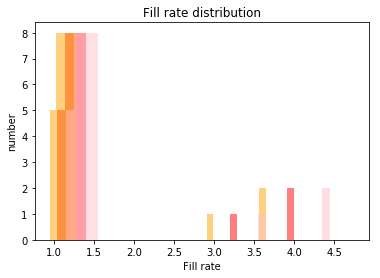

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
fillmean=fmean.tolist()
fillup=fup.tolist()
filllow=flow.tolist()
print(fillmean)
fp1=plt.hist(fillmean, bins=5, normed=0,facecolor='red', alpha=0.5,rwidth=0.5,label='a')  
fp2=plt.hist(fillup, bins=5, normed=0, facecolor='orange', alpha=0.5,rwidth=0.5,label='graph 2')
fp3=plt.hist(filllow, bins=5, normed=0, facecolor='pink', alpha=0.5,rwidth=0.5,label='graph 3')
plt.title('Fill rate distribution')
plt.xlabel('Fill rate')
plt.ylabel('number')
plt.show()
